In [10]:
import torch
from my_modules.nsclc import NSCLCDataset
from my_modules.custom_models import ResNet18NPlaned, AdaptedInputInceptionResNetV2, CNNet, \
    CometClassifierWithBinaryOutput, FeatureExtractorToClassifier
from my_modules.model_learning.model_metrics import score_model

# Hard-coding patient indices to match randomized patient sampling that originally occurred at runtime
idx = [0, 18, 29, 12, 6, 25, 3, 19]

# FAD-NADH-SHG-ORR
data = NSCLCDataset(root='D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    mode=['fad', 'nadh', 'shg', 'orr'],
                    mask_on=True,
                    label='M')
data.augment()
data.normalize_method = 'preset'

patient_subsets = [data.get_patient_subset(i) for i in idx]
test_idx = [i for subset in patient_subsets for i in subset]

# Make loader
batch_size = 64
test_set = torch.utils.data.Subset(data, test_idx)
test_loader =  torch.utils.data.DataLoader(test_set,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=0, 
                                           drop_last=(True if len(test_idx) % batch_size == 1 else False))


In [11]:
# Add model architectures and load
models = [ResNet18NPlaned(data.shape, start_width=64, n_classes=1)]
models[0].load_state_dict(torch.load(
    'C:/Users/jdivers/Desktop/Results/fad-nadh-shg-orr/Resnet18/Epochs 250 4-Planed ResNet18.pth',
     map_location=torch.device('cpu')))
feature_extractor = AdaptedInputInceptionResNetV2(data.shape,
                                                  num_classes=1000, 
                                                  pretrained=False)
classifier = CometClassifierWithBinaryOutput
models.append(FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier,
                                           layer='inceptionresnetv2.conv2d_7b'))
models[1].load_state_dict(torch.load(
    'C:/Users/jdivers/Desktop/Results/fad-nadh-shg-orr/InceptionResnetV2/Epochs 500 AdaptedInputInceptionResNetV2 Features to type Classifier.pth',  
    map_location=torch.device('cpu')))

Cache opened.


C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:562: RuntimeWarning: 
<class 'RuntimeError'> error caught during ordered layer search
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small
  warnings.warn(f'\n{type(e)} error caught during ordered layer search\n{e}', RuntimeWarning)
C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:679: RuntimeWarning: 
<class 'RuntimeError'> error caught during feature extraction
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small
  warnings.warn(f'\n{type(e)} error caught during feature extraction\n{e}', RuntimeWarning)


<All keys matched successfully>

_____________________________________________________
|	ROC-AUC                                 0.7393	|
|	Optimal Threshold from ROC              0.5797	|
|	F1 Score                                0.7541	|
|	Optimal Threshold from F1               0.5039	|
|	Average Precision                       0.6889	|
|	Accuracy at Threshold                   0.6980	|
|	Balanced Accuracy at Threshold          0.6957	|
_____________________________________________________
_____________________________________________________
|	ROC-AUC                                 0.7097	|
|	Optimal Threshold from ROC              0.4975	|
|	F1 Score                                0.7266	|
|	Optimal Threshold from F1               0.4842	|
|	Average Precision                       0.6983	|
|	Accuracy at Threshold                   0.6857	|
|	Balanced Accuracy at Threshold          0.6843	|
_____________________________________________________


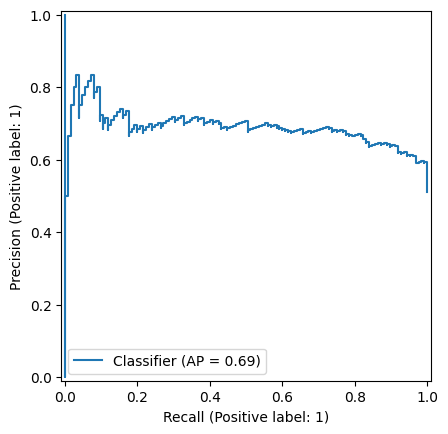

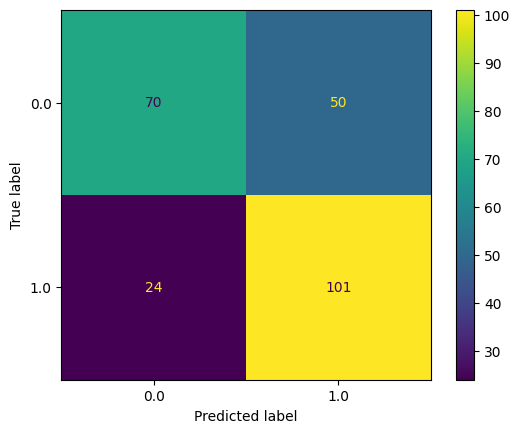

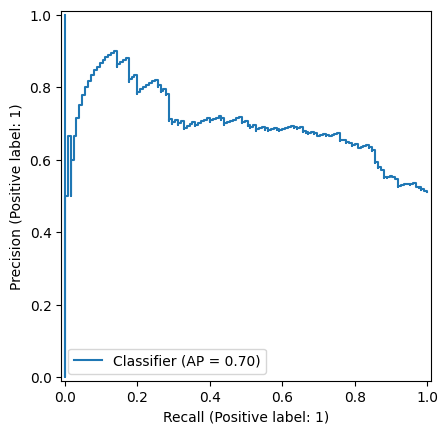

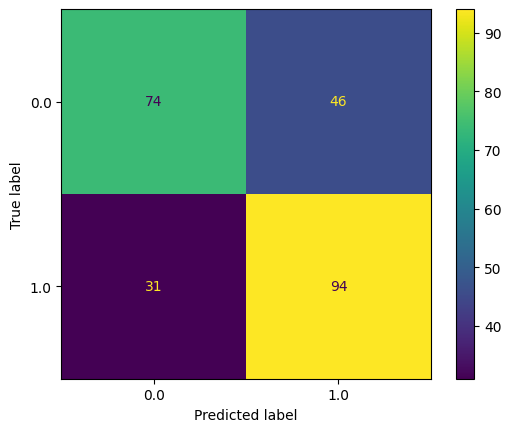

In [15]:
# Testing
import matplotlib.pyplot as plt
for model in models:
    scores, fig = score_model(model, test_loader, print_results=True, make_plot=True, threshold_type='roc')
    fig.savefig(f'{model.name} test plots.png')
    plt.close(fig)

In [32]:
import pandas as pd
# Make loss and AUC plots
mod_dir = 'C:/Users/jdivers/Desktop/Results/fad-nadh-shg-orr/InceptionResnetV2/'
table = pd.read_csv(f'{mod_dir}/fad-nadh-shg-orr-inceptionresnetv2-losses_auc_2500_tabular.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(table['Epoch'][0:500], table['Training Loss (average per sample)'][0:500], label='Training Loss')
ax1.plot(table['Epoch'][0:500], table['Evaluation Loss (average per sample)'][0:500], label='Evaluation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Losses')
ax1.legend()

ax2.plot(table['Epoch'][0:500], table['Training ROC-AUC'][0:500], label='Training ROC-AUC')
ax2.plot(table['Epoch'][0:500], table['Evaluation ROC-AUC'][0:500], label='Evaluation ROC-AUC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Training and Evaluation ROC-AUC')
ax2.legend()

fig.savefig(f'{mod_dir}/training plots.png')
plt.close(fig)

In [42]:
# Make loss and AUC plots
mod_dir = 'C:/Users/jdivers/Desktop/Results/fad-nadh-shg-orr/Resnet18/'
table = pd.read_csv(f'{mod_dir}/fad-nadh-shg-orr-resnet18-losses_auc_2500_tabular.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(table['Epoch'][0:250], table['Training Loss (average per sample)'][0:250], label='Training Loss')
ax1.plot(table['Epoch'][0:250], table['Evaluation Loss (average per sample)'][0:250], label='Evaluation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Losses')
ax1.legend()

ax2.plot(table['Epoch'][0:250], table['Training ROC-AUC'][0:250], label='Training ROC-AUC')
ax2.plot(table['Epoch'][0:250], table['Evaluation ROC-AUC'][0:250], label='Evaluation ROC-AUC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Training and Evaluation ROC-AUC')
ax2.legend()

fig.savefig(f'{mod_dir}/training plots.png')
plt.close(fig)

_____________________________________________________
|	ROC-AUC                                 0.7285	|
|	Optimal Threshold from ROC              0.6608	|
|	F1 Score                                0.7643	|
|	Optimal Threshold from F1               0.6102	|
|	Average Precision                       0.6506	|
|	Accuracy at Threshold                   0.7020	|
|	Balanced Accuracy at Threshold          0.7007	|
_____________________________________________________


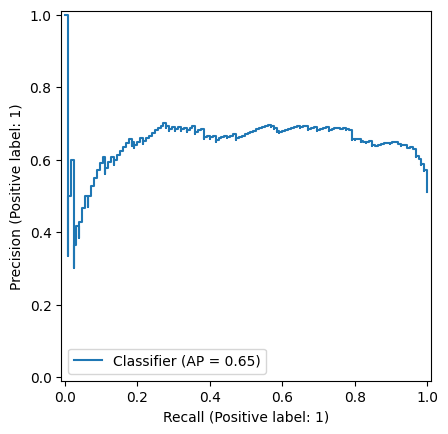

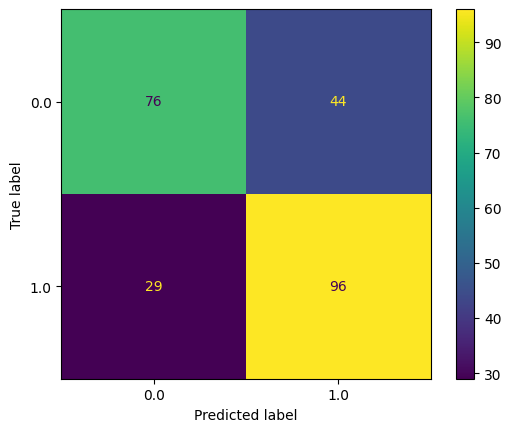

In [36]:
data.mode = ['fad', 'nadh', 'shg']

# Add model architectures and load
models = [ResNet18NPlaned(data.shape, start_width=64, n_classes=1)]
models[0].load_state_dict(torch.load(
    'C:/Users/jdivers/Desktop/Results/fad-nadh-shg/Resnet18/Epochs 1500 3-Planed ResNet18.pth',
     map_location=torch.device('cpu')))
for model in models:
    scores, fig = score_model(model, test_loader, print_results=True, make_plot=True, threshold_type='roc')
    fig.savefig(f'{model.name} test plots.png')
    plt.close(fig)

In [43]:
# Make loss and AUC plots
mod_dir = 'C:/Users/jdivers/Desktop/Results/fad-nadh-shg/Resnet18/'
table = pd.read_csv(f'{mod_dir}/fad-nadh-shg-resnet-losses_auc_2500_tabular.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(table['Epoch'][0:1500], table['Training Loss (average per sample)'][0:1500], label='Training Loss')
ax1.plot(table['Epoch'][0:1500], table['Evaluation Loss (average per sample)'][0:1500], label='Evaluation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Losses')
ax1.legend()

ax2.plot(table['Epoch'][0:1500], table['Training ROC-AUC'][0:1500], label='Training ROC-AUC')
ax2.plot(table['Epoch'][0:1500], table['Evaluation ROC-AUC'][0:1500], label='Evaluation ROC-AUC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Training and Evaluation ROC-AUC')
ax2.legend()

fig.savefig(f'{mod_dir}/training plots.png')
plt.close(fig)

_____________________________________________________
|	ROC-AUC                                 0.6479	|
|	Optimal Threshold from ROC              0.5776	|
|	F1 Score                                0.7030	|
|	Optimal Threshold from F1               0.1660	|
|	Average Precision                       0.6685	|
|	Accuracy at Threshold                   0.6122	|
|	Balanced Accuracy at Threshold          0.6108	|
_____________________________________________________


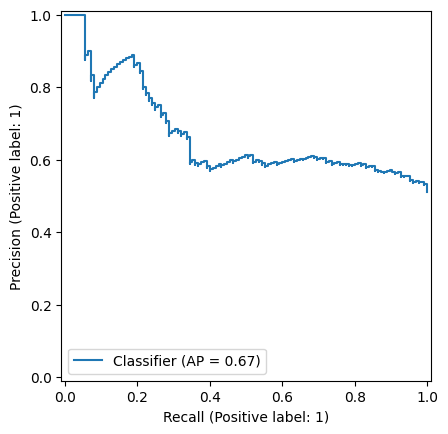

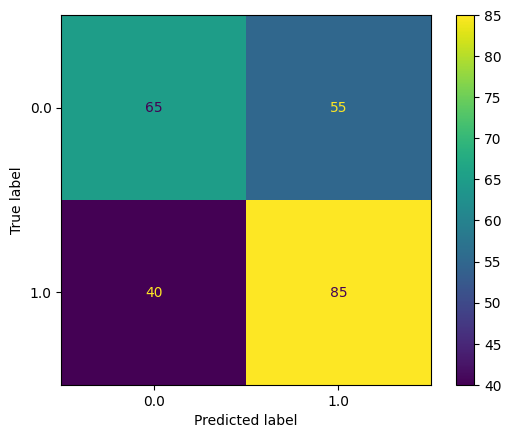

In [44]:
data.mode = ['shg', 'orr', 'intensity']

# Add model architectures and load
models = [CNNet(data.shape)]
models[0].load_state_dict(torch.load(
    'C:/Users/jdivers/Desktop/Results/shg-orr-intensity/cnn/Epochs 1500 CN Net.pth',
     map_location=torch.device('cpu')))
for model in models:
    scores, fig = score_model(model, test_loader, print_results=True, make_plot=True, threshold_type='roc')
    fig.savefig(f'{model.name} test plots.png')
    plt.close(fig)

In [41]:
# Make loss and AUC plots
mod_dir = 'C:/Users/jdivers/Desktop/Results/shg-orr-intensity/cnn'
table = pd.read_csv(f'{mod_dir}/tabular.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(table['Epoch'][0:1500], table['Training Loss (average per sample)'][0:1500], label='Training Loss')
ax1.plot(table['Epoch'][0:1500], table['Evaluation Loss (average per sample)'][0:1500], label='Evaluation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Losses')
ax1.legend()

ax2.plot(table['Epoch'][0:1500], table['Training ROC-AUC'][0:1500], label='Training ROC-AUC')
ax2.plot(table['Epoch'][0:1500], table['Evaluation ROC-AUC'][0:1500], label='Evaluation ROC-AUC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Training and Evaluation ROC-AUC')
ax2.legend()

fig.savefig(f'{mod_dir}/training plots.png')
plt.close(fig)